In [22]:
import torch
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [23]:
# مسیر به پوشه تصاویر و فایل JSON
data_dir = 'dataset/'           # مسیر پوشه تصاویر
ann_file = 'dataset/annotations/instances_Train.json'   # مسیر فایل JSON

In [24]:
# تنظیمات پیش‌پردازش شامل تغییر اندازه و نرمال‌سازی
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه به 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Pre Train

In [25]:
# بارگذاری داده‌ها با فرمت COCO
coco_dataset = CocoDetection(root=data_dir, annFile=ann_file, transform=transform)

# ایجاد DataLoader برای مدیریت داده‌ها
data_loader = DataLoader(coco_dataset, batch_size=32, shuffle=True)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Data Augmentation

In [26]:
# افزودن تغییرات تصادفی به تصاویر برای افزایش داده‌ها
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Test Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


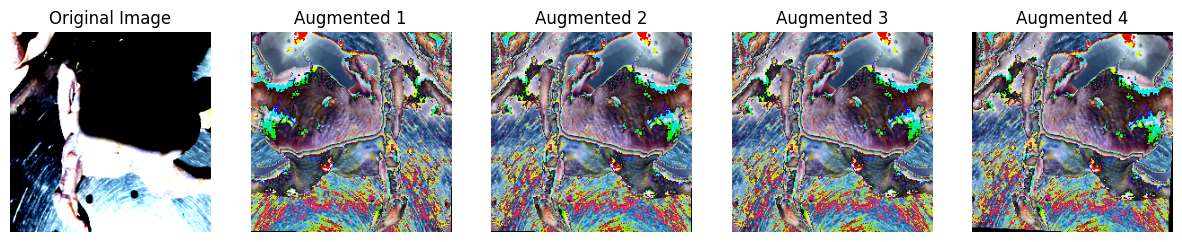

In [27]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

# تنظیم Augmentation ساده و طبیعی
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(3),  # چرخش بسیار محدود به 3 درجه
    transforms.Resize((224, 224))  # تغییر اندازه به 224x224 بدون برش
])

# تعداد نمونه‌های مورد نظر برای نمایش (یک تصویر اصلی و بقیه Augmented)
num_samples = 5

# انتخاب یک تصویر تصادفی از دیتاست
image, _ = coco_dataset[random.randint(0, len(coco_dataset) - 1)]

# نمایش تصویر اصلی و نمونه‌های Augmented
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# نمایش تصویر اصلی در اولین ستون
axes[0].imshow(image.permute(1, 2, 0))
axes[0].set_title("Original Image")
axes[0].axis('off')

# نمایش تصاویر Augmented در ستون‌های بعدی
for i in range(1, num_samples):
    pil_image = transforms.ToPILImage()(image)
    augmented_image = augmentation_transform(pil_image)  # اعمال Augmentation روی PIL Image

    # تبدیل تصویر Augmented به Tensor و نمایش
    augmented_image = transforms.ToTensor()(augmented_image)
    axes[i].imshow(augmented_image.permute(1, 2, 0))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.show()


In [30]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import random_split, DataLoader

# تنظیمات اولیه
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.0003

# تنظیمات پیش‌پردازش شامل تغییر اندازه ثابت
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # تغییر اندازه ثابت به 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

coco_dataset.transform = transform

# تعریف collate_fn برای یکنواخت‌سازی ابعاد تصاویر
def collate_fn(batch):
    images, targets = zip(*batch)
    images = [transform(Image.fromarray(img.numpy().transpose(1, 2, 0))) if isinstance(img, torch.Tensor) else transform(img) for img in images]
    images = torch.stack(images)  # تبدیل لیست تصاویر به Tensor
    return images, targets

# تقسیم داده‌ها به آموزشی و تست
train_size = int(0.8 * len(coco_dataset))
test_size = len(coco_dataset) - train_size
train_dataset, test_dataset = random_split(coco_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# بارگذاری و تنظیم مدل InceptionV3
model = models.inception_v3(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # تنظیم خروجی برای دو کلاس
model = model.to(device)

# تنظیمات آموزش
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# آموزش مدل
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = images.to(device)
        targets = torch.tensor([t['category_id'] for t in targets]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# ذخیره مدل
torch.save(model.state_dict(), "chicken_freshness_model.pth")

# تابع پیش‌بینی
def predict_image(model, image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    
    classes = ["Fresh", "Deforest"]
    result = classes[predicted.item()]
    print(f"The model predicts this image as: {result}")
    return result

# تست پیش‌بینی
image_path = 'dataset/test/deforest/IMG_4105.jpg'
predict_image(model, image_path)


TypeError: Cannot handle this data type: (1, 1, 3), <f4